# Data Exploration and PreProcessing Notebook
Welcome to the Data Exploration and Preprocessing Notebook for our project, delivered in Part 1 of our data science endeavor. This Jupyter notebook serves as a comprehensive guide detailing the exploration and preprocessing steps applied to the raw data. Our objective is to provide insight into the initial stages of our data analysis pipeline, including data cleansing, feature engineering, and any transformations performed on the dataset.

In this notebook, we will embark on a journey to uncover the intricacies of our dataset, understand its structure, identify potential issues, and prepare it for further analysis. By meticulously exploring and preprocessing the data, we aim to lay a solid foundation for subsequent stages of our project, enabling us to derive meaningful insights and build robust machine learning models.

## Each feature provides valuable insights into the health profile of individuals. Here's a quick overview of the key features:

- **HeartDisease:** Indicates the presence (1) or absence (0) of heart disease.
- **Smoking:** Reflects smoking habits (1 for Yes, 0 for No).
- **AlcoholDrinking:** Captures alcohol consumption habits (1 for Yes, 0 for No).
- **Stroke:** Indicates whether an individual had a stroke (1 for Yes, 0 for No).
- **DiffWalking:** Reflects difficulty walking (1 for Yes, 0 for No).
- **Sex:** Represents gender (1 for Male, 0 for Female).
- **AgeCategory:** Categorizes age into groups, such as 18-24, 25-29, ..., 80 or older.
- **Race:** Classifies individuals into different racial categories (e.g., White, Black, Hispanic).
- **Diabetic:** Indicates diabetic status (0 for No, 1 for Yes).
- **PhysicalActivity:** Reflects engagement in physical activity (1 for Yes, 0 for No).
- **GenHealth:** Rates general health on a scale from Excellent (1) to Poor (5).
- **Asthma:** Indicates asthma status (1 for Yes, 0 for No).
- **KidneyDisease:** Reflects the presence (1) or absence (0) of kidney disease.
- **SkinCancer:** Indicates whether an individual has skin cancer (1 for Yes, 0 for No).

In [165]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap
from scipy.stats import entropy, ttest_ind, f_oneway, ttest_rel, wilcoxon, kruskal, friedmanchisquare, probplot, shapiro
from scipy.fftpack import fft
from mrmr import mrmr_classif
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

In [166]:
class DataLoader:

    def __init__(self, filename, target):
        """
        Initializes the DataLoader with the filename of the dataset,
        the proportion of data to include in the test split,
        and the random state for reproducibility.
        """
        self.filename = filename

        self.data = None
        self.labels = None
        self.numerical_features = []
        self.categorical_features = []

        # Load data
        self._load_data(target)

    def _load_data(self, target):
        """
        Loads the dataset from the specified filename,
        splits it into training and testing sets using train_test_split(),
        and assigns the data and labels to the appropriate attributes.
        """
        try:
            # Load the dataset
            self.data = pd.read_csv(self.filename)

            self.data.target = target

            # Validate if the target column exists in the dataset
            if target not in self.data.columns:
                raise ValueError(f"Target column '{target}' not found in the dataset.")

            self.labels = self.data[target]

            print("Data loaded successfully.")

        except FileNotFoundError:
            print("File not found. Please check the file path.")

In [167]:
class DataManipulator(DataLoader):

    def __init__(self, filename, target):

        super().__init__(filename, target)

        print("\nData Description:")
        self.describe_variables()

    def describe_variables(self):
        print("\nInformation of Data:")
        print(self.data.info())

        print("\nUnique values of features:")
        print(self.data.nunique())

        print("\nStatistical distribution of each variable:")
        print(self.data.describe())

In [168]:
class DataPreProcessing:

    def __init__(self, data_loader):
        """
        Initializes the DataPreprocessing class with a DataLoader object.
        """
        self.data_loader = data_loader

        self.encode_data()

        self.determine_range()

    def determine_range(self):

        # Display the range of values for each variable without considering the class label
        print("\nRange of values for each variable:")
        print(self.data_loader.data.max() - self.data_loader.data.min())

    def _age_encode(self):
        age = self.data_loader.data["AgeCategory"]
        condition = [
            age == "18-24", age == "25-29",
            age == "30-34", age == "35-39",
            age == "40-44", age == "45-49",
            age == "50-54", age == "55-59",
            age == "60-64", age == "65-69",
            age == "70-74", age == "75-79",
            age == "80 or older"
        ]
        choice = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
        self.data_loader.data["AgeCategory"] = np.select(condition, choice, default=0)

    def _race_encode(self):
        race = self.data_loader.data["Race"]
        condition = [
            race == "White", race == "Black",
            race == "Hispanic", race == "Asian",
            race == "American Indian/Alaskan Native", race == "Other"]
        choice = [1, 2, 3, 4, 5, 6]
        self.data_loader.data["Race"] = np.select(condition, choice)

    def _gen_health_encode(self):
        gen_health = self.data_loader.data["GenHealth"]
        condition = [
            gen_health == "Excellent", gen_health == "Very good",
            gen_health == "Good", gen_health == "Fair",
            gen_health == "Poor"]
        choice = [1, 2, 3, 4, 5]
        self.data_loader.data["GenHealth"] = np.select(condition, choice)

    def encode_data(self):

        # Map categorical features to numerical values
        self.data_loader.data["HeartDisease"] = self.data_loader.data["HeartDisease"].map({"No": 0, "Yes": 1})
        self.data_loader.data["Smoking"] = self.data_loader.data["Smoking"].map({"No": 0, "Yes": 1})
        self.data_loader.data["AlcoholDrinking"] = self.data_loader.data["AlcoholDrinking"].map({"No": 0, "Yes": 1})
        self.data_loader.data["Stroke"] = self.data_loader.data["Stroke"].map({"No": 0, "Yes": 1})
        self.data_loader.data["DiffWalking"] = self.data_loader.data["DiffWalking"].map({"No": 0, "Yes": 1})
        self.data_loader.data["Sex"] = self.data_loader.data["Sex"].map({"Female": 0, "Male": 1})
        self.data_loader.data["Diabetic"] = self.data_loader.data["Diabetic"].map(
            {"No": 0, "No, borderline diabetes": 0, "Yes (during pregnancy)": 1, "Yes": 1})
        self.data_loader.data["PhysicalActivity"] = self.data_loader.data["PhysicalActivity"].map({"No": 0, "Yes": 1})
        self.data_loader.data["Asthma"] = self.data_loader.data["Asthma"].map({"No": 0, "Yes": 1})
        self.data_loader.data["KidneyDisease"] = self.data_loader.data["KidneyDisease"].map({"No": 0, "Yes": 1})
        self.data_loader.data["SkinCancer"] = self.data_loader.data["SkinCancer"].map({"No": 0, "Yes": 1})

        # Encode numerical features
        self._age_encode()
        self._race_encode()
        self._gen_health_encode()

        print("\nProcessed Dataset:")
        print(self.data_loader.data.info())

        # Iterate over columns and categorize them
        for column in self.data_loader.data.columns:
            if len(self.data_loader.data[column].unique()) > 2:
                self.data_loader.numerical_features.append(column)
            else:
                self.data_loader.categorical_features.append(column)

In [169]:
class DataCleaning:
    """
    Class for cleaning operations.

    Methods:
        remove_duplicates(): Remove duplicate rows from the dataset.
        handle_missing_values(strategy='mean'): Handle missing values using the specified strategy.
        remove_outliers(threshold=3): Remove outliers from the dataset
    """

    def __init__(self, data_loader):

        self.data_loader = data_loader

        print("\nOriginal Dataset before cleaning:")
        print(self.data_loader.data.info())

    def handle_missing_values(self):

        print("Missing values:\n", self.data_loader.data.isnull().sum())

        if self.data_loader.data.isnull().sum().sum() > 0:
            self.data_loader.data = self.data_loader.data.dropna()

    def remove_duplicates(self):

        print("Duplicate Rows:", self.data_loader.data.duplicated().sum())

        if self.data_loader.data.duplicated().sum() > 0:
            self.data_loader.data = self.data_loader.data.drop_duplicates(keep='first')
            self.data_loader.data.target = 'HeartDisease'

    def detect_and_remove_outliers(self):

        print("\nDetecting outliers (only numerical values):")
        features_to_delete = []
        for feature in self.data_loader.data:

            # Check if the feature is binary (0 or 1)
            if set(self.data_loader.data[feature]) == {0, 1}:
                # Skip processing binary features
                continue

            q1 = self.data_loader.data[feature].quantile(0.25)
            q3 = self.data_loader.data[feature].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers_indices = self.data_loader.data[
                (self.data_loader.data[feature] < lower_bound) | (self.data_loader.data[feature] > upper_bound)].index

            print(f"Outliers in '{feature}'." if not outliers_indices.empty else f"No outliers in '{feature}'.")

            self.data_loader.data.drop(outliers_indices, inplace=True)

            # Verify if the feature after removing outliers has only one unique value
            if len(self.data_loader.data[feature].unique()) == 1:
                print(f"Feature '{feature}' has only one unique value after removing outliers. Deleting it.")
                features_to_delete.append(feature)

        # Remove features with only one unique value
        self.data_loader.data.drop(columns=features_to_delete, inplace=True)

In [170]:
class DataVisualization:

    def __init__(self, data_loader):
        """
        Initializes the EDA class with a DataLoader object.
        """
        self.data_loader = data_loader

        self.valid_plot_types = ['count', 'hist', 'correlation', 'box', 'barh']

        self.feature_names = self.data_loader.data.columns.tolist()
        self.labels = self.data_loader.data['HeartDisease'].unique().tolist()

    def plot_all_features(self): 

        num_features = len(self.feature_names)
        num_cols = 3  # Adjust the number of columns to control subplot arrangement
        num_rows = int(np.ceil(num_features / num_cols))

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

        for idx, ax in enumerate(axes.flat):
            if idx < num_features:
                ax.set_title(f'Feature {self.feature_names[idx]}', fontsize=12)
                ax.set_xlabel('Value', fontsize=10)
                ax.set_ylabel('Frequency', fontsize=10)
                ax.grid(True)

                if self.labels is not None:
                    # Add a plot per feature and label
                    for label in self.labels:
                        mask = np.array(self.data_loader.data['HeartDisease'] == label)
                        ax.hist(self.data_loader.data.loc[mask, self.feature_names[idx]], bins=20, alpha=0.7, label=label)
                    ax.legend()

        plt.tight_layout()
        plt.show()

    def plots(self, plot_types):
        for plot_type in plot_types:
            # Check if the selected plots are in the list of available plots
            if plot_type not in self.valid_plot_types:
                print(
                    f"Ignoring invalid plot type: {plot_type}. Supported plot types: {', '.join(self.valid_plot_types)}")
                continue

            for feature in self.data_loader.data.columns:
                # Create a figure with a single subplot for each feature
                if plot_type == 'count' and feature in self.data_loader.categorical_features:
                    fig, ax = plt.subplots(figsize=(8, 6))
                    sns.countplot(x=feature, data=self.data_loader.data, hue=self.data_loader.data.target, ax=ax)
                    ax.set_title(f'Countplot of {feature} by {self.data_loader.data.target}')
                    plt.show()
                if plot_type == 'box' and feature in self.data_loader.numerical_features:
                    fig, ax = plt.subplots(figsize=(8, 6))
                    sns.boxplot(x='AlcoholDrinking', y=feature, data=self.data_loader.data, ax=ax, hue=self.data_loader.data.target)
                    ax.set_title(f'Boxplot of {feature} by {self.data_loader.data.target}')
                    plt.show()

        if 'correlation' in plot_types:
            correlation = self.data_loader.data.corr().round(2)
            heartdisease_correlation = correlation['HeartDisease'].sort_values(ascending=False)

            plt.figure(figsize=(15, 12))
            sns.heatmap(correlation, annot=True, cmap='YlOrBr', annot_kws={'size': 8})
            plt.title('Correlation Heatmap')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            print("\nCorrelation of the features with Heart Disease:\n")
            print(heartdisease_correlation)

        if 'barh' in plot_types:
            # Train a RandomForestClassifier model
            clf = RandomForestClassifier()
            X = self.data_loader.data.drop(columns=[self.data_loader.data.target])  # Features
            y = self.data_loader.data[self.data_loader.data.target]  # Target variable
            clf.fit(X, y)

            # Calculate permutation importance
            result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
            perm_sorted_idx = result.importances_mean.argsort()

            # Visualize feature importance
            plt.figure(figsize=(10, 8))
            sns.barplot(x=result.importances_mean[perm_sorted_idx], y=X.columns[perm_sorted_idx])
            plt.xlabel('Permutation Importance')
            plt.ylabel('Features')
            plt.title('Permutation Importance')
            plt.show()

In [171]:
class DimensionalityReduction:
    def __init__(self, data_loader):
        """
        Initialize the DimensionalityReduction object with the dataset.
        """
        self.data_loader = data_loader

        # Sample 20% of the data
        self.dataset = self.data_loader.data.sample(frac=0.05, random_state=42)

        self.data = StandardScaler().fit_transform(self.data_loader.data.drop(columns=['HeartDisease']))
        self.target = self.data_loader.data['HeartDisease']

    def plot_projection(self, projection, title):
        """
        Plot the 2D projection of the dataset.

        Parameters:
        - projection: The projected data.
        - title: The title of the plot.
        """
        plt.figure(figsize=(8, 6))
        if projection.shape[1] == 1:
            plt.scatter(projection, np.zeros_like(projection), c=self.target, alpha=0.5)
        else:
            plt.scatter(projection[:, 0], projection[:, 1], c=self.target, alpha=0.5)
        plt.title(title)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True)
        plt.show()

    def compute_pca(self, n_components=2):
        """
        Compute Principal Component Analysis (PCA) on the dataset.

        Parameters:
        - n_components: The number of components to keep.

        Returns:
        - pca_projection: The projected data using PCA.
        """
        return PCA(n_components=n_components).fit_transform(self.data)

    def compute_tsne(self, n_components=2, perplexity=3):
        """
        Compute t-Distributed Stochastic Neighbor Embedding (t-SNE) on the dataset.

        Parameters:
        - n_components: The number of components to embed the data into.
        - perplexity: The perplexity parameter for t-SNE.

        Returns:
        - tsne_projection: The projected data using t-SNE.
        """
        return TSNE(n_components=n_components, perplexity=perplexity).fit_transform(self.data)

    def compute_umap(self, n_components=2, n_neighbors=8, min_dist=0.5, metric='euclidean'):
        """
        Compute Uniform Manifold Approximation and Projection (UMAP) on the dataset.

        Parameters:
        - n_components: The number of components to embed the data into.
        - n_neighbors: The number of neighbors to consider for each point.
        - min_dist: The minimum distance between embedded points.
        - metric: The distance metric to use.

        Returns:
        - umap_projection: The projected data using UMAP.
        """
        return umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist,
                         metric=metric).fit_transform(self.data)

In [172]:
class DataAnalysis:
    def __init__(self, data_loader):
        """
        Initialize the DataAnalysis class.

        Parameters:
        - dataset (array-like): The dataset to be analyzed.
        - labels (array-like): The labels corresponding to each of the dataset samples.
        - columns_names (list): List of column (features) names for the dataset.

        This method initializes the DataAnalysis class by setting up the attributes
        for the dataset, labels, and column names.
        """
        self.data_loader = data_loader

        self.valid_plot_types = ['count', 'hist', 'kde', 'correlation', 'box', 'split_violin', 'barh']

    def bmi_class(self):
        bmi = self.df["BMI"]
        condition = [bmi < 16, bmi < 17, bmi < 18.5, bmi < 25, bmi < 30, bmi < 35, bmi < 40, bmi >= 40]
        choice = [1, 2, 3, 4, 5, 6, 7, 8]
        self.df["BMIClass"] = np.select(condition, choice)

    def sleep_class(self):
        sleep = self.df["SleepTime"]
        condition = [sleep < 6, sleep < 9, sleep >= 9]
        choice = [1, 2, 3]
        self.df["SleepClass"] = np.select(condition, choice)

    def badHealth_feature(self):
        smoker = self.df["Smoking"]
        alcohol = self.df["AlcoholDrinking"]
        stroke = self.df["Stroke"]
        diffWalk = self.df["DiffWalking"]
        diabetic = self.df["Diabetic"]
        asthma = self.df["Asthma"]

        condition = (smoker + alcohol + stroke + diffWalk + diabetic + asthma)

        self.df["BadHealthScore"] = condition

In [173]:
class HypothesisTester:

    def unpaired_anova(self, *groups):
        """
        Perform unpaired ANOVA for more than two groups.

        Parameters:
        - *groups: Variable length argument containing data for each group. Each argument should be a list or array-like
        object.

        Returns:
        - f_statistic: The calculated F-statistic.
        - p_value: The p-value associated with the F-statistic.
        """
        f_statistic, p_value = f_oneway(*groups)
        return f_statistic, p_value

    def wilcoxon_ranksum_test(self, group1, group2):
        """
        Perform Wilcoxon rank-sum test (Mann-Whitney U test) for two independent samples.

        Parameters:
        - group1: List or array-like object containing data for sample 1.
        - group2: List or array-like object containing data for sample 2.

        Returns:
        - statistic: The calculated test statistic.
        - p_value: The p-value associated with the test statistic.
        """
        statistic, p_value = sms.stattools.stats.mannwhitneyu(group1, group2)

        return statistic, p_value

    def kruskal_wallis_test(self, *groups):
        """
        Perform Kruskal-Wallis H test for independent samples.

        Parameters:
        - *groups: Variable length argument containing data for each group. Each argument should be a list or array-like
        object.

        Returns:
        - statistic: The calculated test statistic.
        - p_value: The p-value associated with the test statistic.
        """
        statistic, p_value = kruskal(*groups)
        return statistic, p_value

    def qq_plots(self, variable_names, *data_samples, distribution='norm'):
        """
        Generate Q-Q plots for multiple data samples.

        Parameters:
        - variable_names: List with the names of the variables to be plotted
        - data_samples: Variable number of 1D array-like objects representing the data samples.
        - distribution: String indicating the theoretical distribution to compare against. Default is 'norm' for normal
        distribution.

        Returns:
        - None (displays the Q-Q plots)
        """
        num_samples = len(data_samples)
        num_rows = (num_samples + 1) // 2  # Calculate the number of rows for subplots
        num_cols = 2 if num_samples > 1 else 1  # Ensure at least 1 column for subplots

        # Adjust the height of the figure to fit all Q-Q plots without overlapping
        fig_height = 6 * num_rows  # Adjust this value as needed
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, fig_height))
        axes = axes.flatten()  # Flatten axes if multiple subplots

        for i, data in enumerate(data_samples):
            ax = axes[i]
            probplot(data, dist=distribution, plot=ax)
            ax.set_title(f'Q-Q Plot ({distribution})')
            ax.set_xlabel('Theoretical Quantiles')
            ax.set_ylabel(variable_names[i])

        # Adjust layout and show plots
        plt.tight_layout()
        plt.show()

    def test_normality(self, variable_names, *data_samples):
        """
        Test the normality of multiple data samples using Shapiro-Wilk test.

        Parameters:
        - variable_names: List with the names of the variables to be tested.
        - data_samples: Variable number of 1D array-like objects representing the data samples.

        Returns:
        - results: Dictionary containing the test results for each data sample.
                   The keys are the variable names and the values are a tuple (test_statistic, p_value) for
                   Shapiro-Wilk test.
        """

        print('\nNormality Test:\n')

        results = {}
        for name, data in zip(variable_names, data_samples):
            results[name] = shapiro(data)
        for variable_name, shapiro_result in results.items():
            print(f'{variable_name}:')
            print(f'Shapiro-Wilk test - Test statistic: {shapiro_result.statistic}, p-value: {shapiro_result.pvalue}')
        return results

In [174]:
class FeatureExtractor:
    """
    A class to extract various types of features from a dataset.
    """

    def __init__(self, dataset):
        """
        Initializes the FeatureExtractor object.

        Parameters:
        - data (numpy.ndarray): The input dataset.
        """
        self.data = dataset

        self.feature_names = self.data.columns.tolist()
        self.labels = self.data['HeartDisease'].unique().tolist()

        self.all_features = []

    def _statistical_features(self):
        """
        Computes statistical features per sample (row) of the dataset.

        Returns:
        - numpy.ndarray: An array containing statistical features per sample.
        """
        # Compute statistical features
        mean = np.mean(self.data, axis=1)
        std_dev = np.std(self.data, axis=1)
        median = np.median(self.data, axis=1)
        min_val = np.min(self.data, axis=1)
        max_val = np.max(self.data, axis=1)
        # Append feature names
        self.feature_names.extend(['Mean'])
        self.feature_names.extend(['Std_Dev'])
        self.feature_names.extend(['Median'])
        self.feature_names.extend(['Min'])
        self.feature_names.extend(['Max'])
        return np.column_stack((mean, std_dev, median, min_val, max_val))

    def _pairwise_differences(self):
        num_features = self.data.shape[1]
        pairwise_diff_df = pd.DataFrame()

        for i in range(num_features - 1):
            for j in range(i + 1, num_features):
                feature_name = f'pairwise_diff_{i + 1}_vs_{j + 1}'
                pairwise_diff_df[feature_name] = np.abs(self.data.iloc[:, i] - self.data.iloc[:, j])
                self.feature_names.append(feature_name)

        return pairwise_diff_df

    def _frequency_domain_features(self):
        """
        Computes frequency domain features per sample (row) of the dataset using FFT.

        Returns:
        - numpy.ndarray: An array containing frequency domain features per sample.
        """
        # Compute frequency domain features using FFT
        fft_result = fft(self.data)
        # Append feature names
        self.feature_names.extend(['FFT'])
        return np.abs(fft_result).mean(axis=1).reshape(-1, 1)

    def _entropy_features(self):

        # Compute entropy-based features for each row
        entropy_vals = np.array([entropy(row) for idx, row in self.data.iterrows()])

        # Append feature names
        self.feature_names.append('Entropy')

        return entropy_vals.reshape(-1, 1)

    def extract_features(self):
        """
        Extracts various types of features from the dataset.

        Returns:
        - pandas.DataFrame: A dataframe containing all extracted features.
        """
        # Extract and combine all features with the original features passed in data
        self.all_features = np.hstack((self.data, self._statistical_features(), self._pairwise_differences(),
                                  self._frequency_domain_features(), self._entropy_features()))
        # Create pandas dataframe
        return pd.DataFrame(data=self.all_features, columns=self.feature_names)

    def plot_all_features(self):
        """
        Plot histograms for all extracted features.
        Each histogram is plotted separately for each feature, with optional coloring based on provided labels.
        """
        num_features = self.all_features.shape[1]
        num_cols = 4  # Adjust the number of columns to control subplot arrangement
        num_rows = int(np.ceil(num_features / num_cols))

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
        fig.suptitle('All Features', fontsize=20)

        for idx, ax in enumerate(axes.flat):
            if idx < num_features:
                ax.set_title(f'Feature {self.feature_names[idx]}', fontsize=12)
                ax.set_xlabel('Value', fontsize=10)
                ax.set_ylabel('Frequency', fontsize=10)
                ax.grid(True)

                if self.labels is not None:
                    # Add a plot per feature and label
                    for label in self.labels:
                        mask = np.array(self.data['HeartDisease'] == label)
                        ax.hist(self.all_features[mask, idx], bins=20, alpha=0.7, label=label)
                    ax.legend()

        plt.tight_layout()
        plt.show()

In [175]:
class FeatureSelector:
    def __init__(self, data, labels):
        """
        Initialize the FeatureSelector instance.

        Parameters:
        - data (numpy.ndarray): The input data array with shape (n_samples, n_features).
        - labels (numpy.ndarray): The labels array with shape (n_samples,).
        """
        self.data = data
        self.labels = labels

        self._sanity_check()

    def _sanity_check(self):
        # Perform basic sanity checks
        print("Dataset Shape:", self.data.shape)

        # Check for missing values
        print("\nMissing Values:")
        print(self.data.isnull().sum())

        # Check data types
        print("\nData Types:")
        print(self.data.dtypes)

        # Check for zero variance features
        zero_variance_features = self.data.columns[self.data.var() == 0]
        print("\nZero Variance Features:", zero_variance_features)

    def select_features_mrmr(self, k=5):
        """
        Select features using mRMR (minimum Redundancy Maximum Relevance).

        Parameters:
        - k (int): The number of features to select. Default is 5.

        Returns:
        - List: The selected features as a list.
        """
        # Return the selected features
        return mrmr_classif(X=self.data, y=self.labels, K=k)

In [176]:
path = '../data/heart_2020.csv'

# Describe Variables

Let's start by examining how many features our dataset has and checking for any null values. As we can see, no feature has null values, as we have 319795 entries for each feature, all of which are non-null. Additionally, we can observe the number of unique values for each feature below. Following that, there is a brief statistical distribution of some features.

In [177]:
data_loader = DataManipulator(path, 'HeartDisease')

Data loaded successfully.

Data Description:

Information of Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  A

# Mapping Categorical Features to Numerical Values

In the initial preprocessing steps, we map categorical features to numerical values to facilitate quantitative analysis. This conversion allows us to work with statistical methods that require numerical inputs. Below is a summary of the mappings performed:

- **HeartDisease:** Mapped "No" to 0 and "Yes" to 1.
- **Smoking:** Mapped "No" to 0 and "Yes" to 1.
- **AlcoholDrinking:** Mapped "No" to 0 and "Yes" to 1.
- **Stroke:** Mapped "No" to 0 and "Yes" to 1.
- **DiffWalking:** Mapped "No" to 0 and "Yes" to 1.
- **Sex:** Mapped "Female" to 0 and "Male" to 1.
- **Diabetic:** Mapped "No" and "No, borderline diabetes" to 0, "Yes (during pregnancy)" and "Yes" to 1.
- **PhysicalActivity:** Mapped "No" to 0 and "Yes" to 1.
- **Asthma:** Mapped "No" to 0 and "Yes" to 1.
- **KidneyDisease:** Mapped "No" to 0 and "Yes" to 1.
- **SkinCancer:** Mapped "No" to 0 and "Yes" to 1.

We observed that the data type of some features was initially stored as 'object.' To enhance our analysis, these features were converted to 'int64'


In [178]:
data_pre_processing = DataPreProcessing(data_loader)


Processed Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  int64  
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  int64  
 8   Sex               319795 non-null  int64  
 9   AgeCategory       319795 non-null  int32  
 10  Race              319795 non-null  int32  
 11  Diabetic          319795 non-null  int64  
 12  PhysicalActivity  319795 non-null  int64  
 13  GenHealth         319795 non-null  int32  
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  int64  
 16  

# Outliers and Correlation
We chose to use AlcoholDrinking as the X-axis in our plots because we observed from various health sources that drinking alcohol is reported to influence cardiovascular diseases. By selecting AlcoholDrinking as the independent variable, we aim to analyze its correlation with the observed health outcomes, particularly in the context o f cardiovascular conditions.
Upon inspecting the plots, we identified outliers in the data.


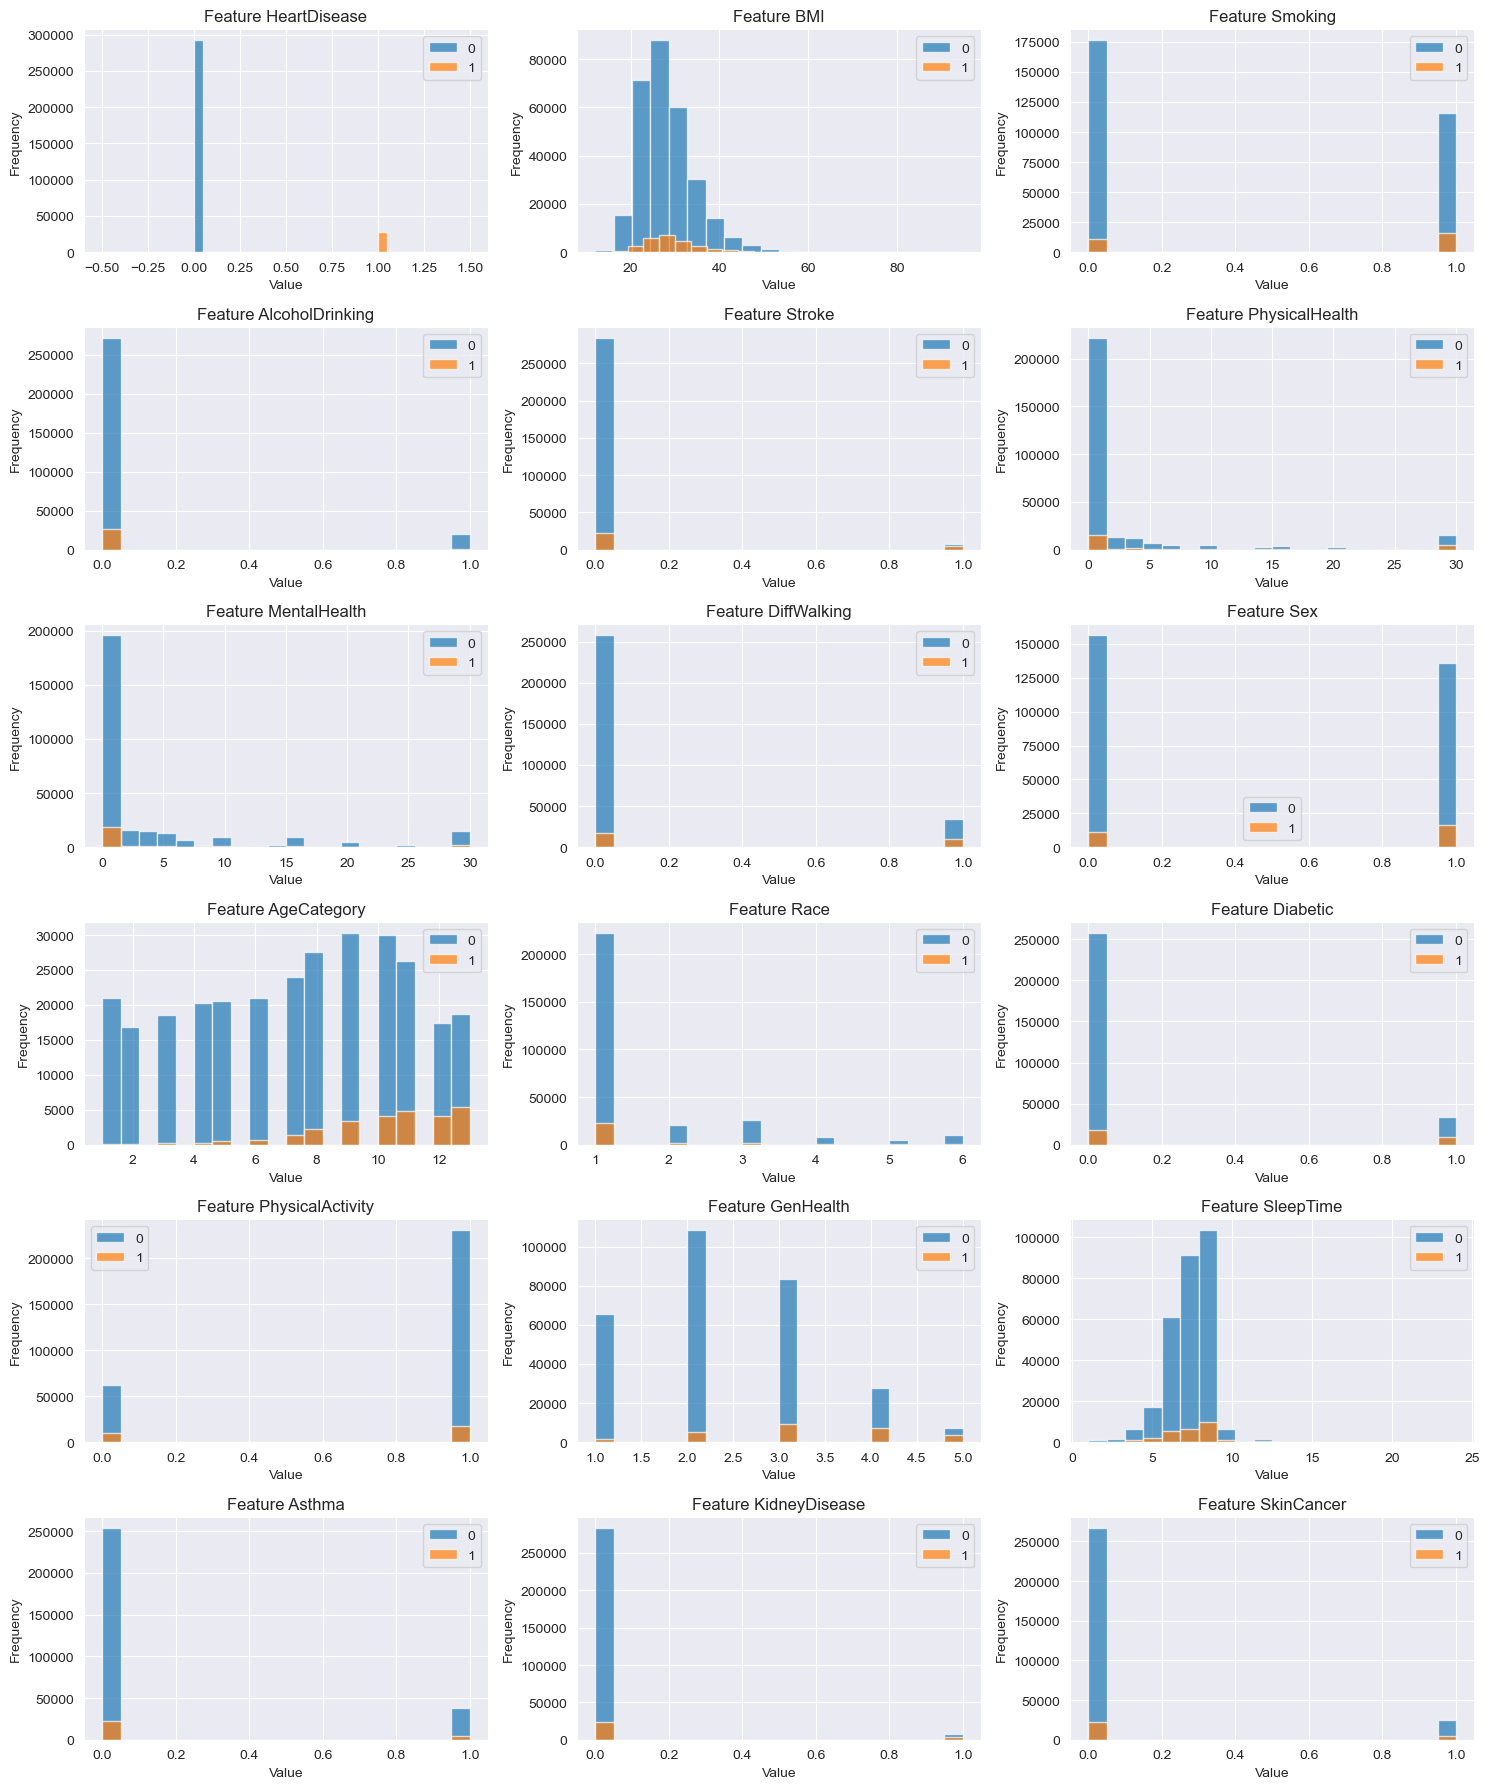

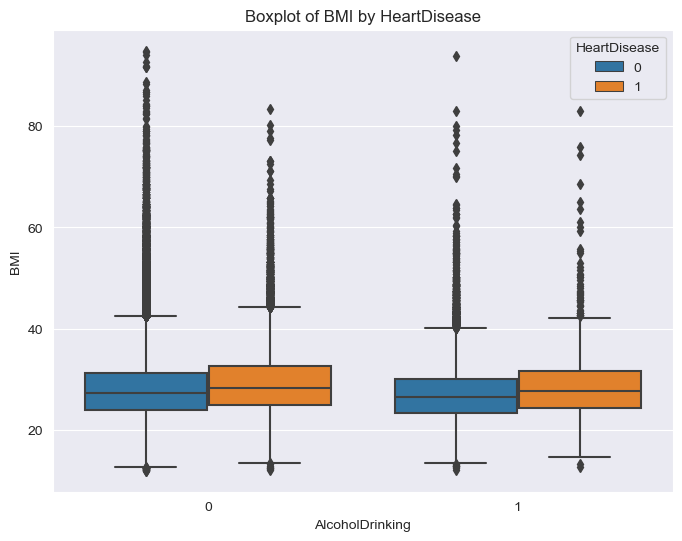

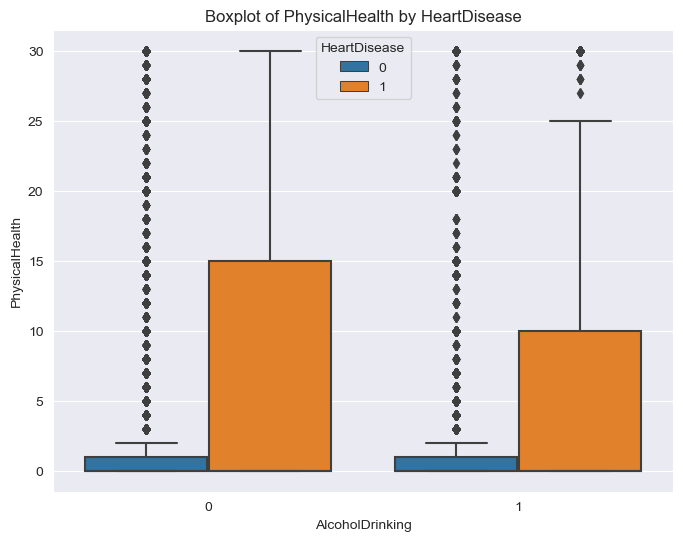

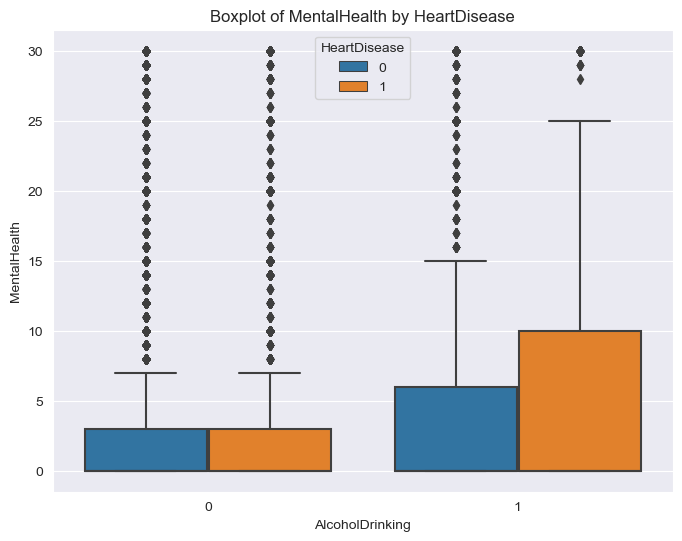

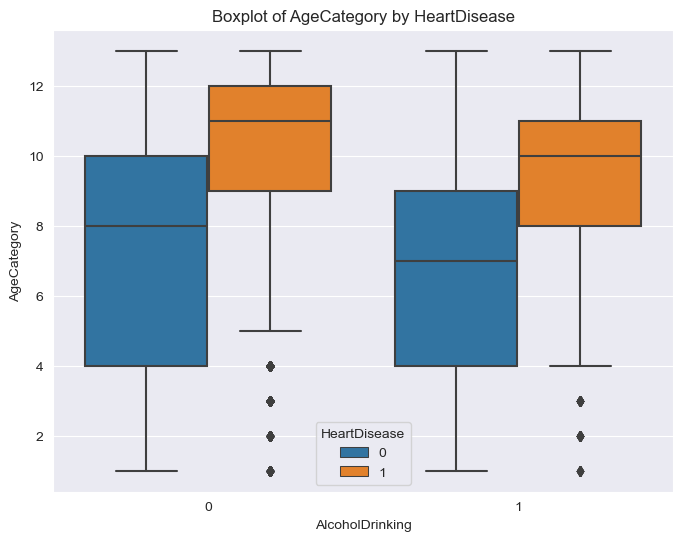

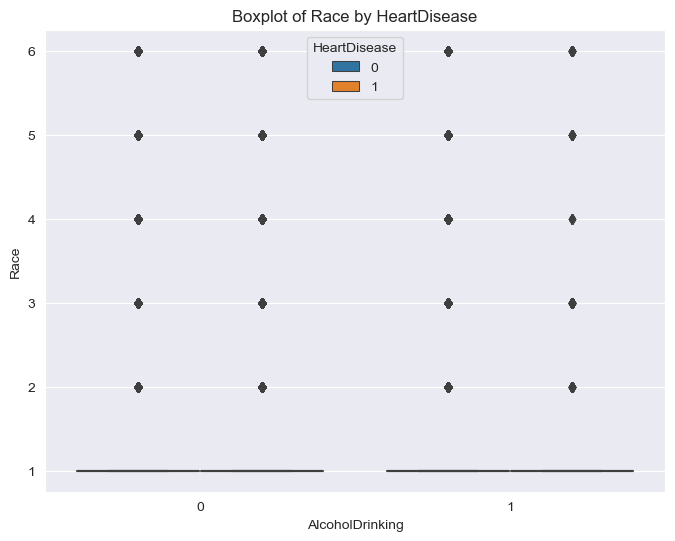

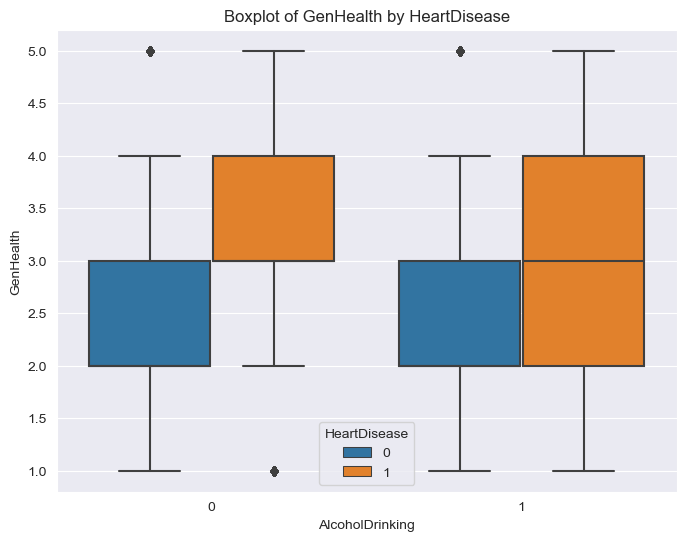

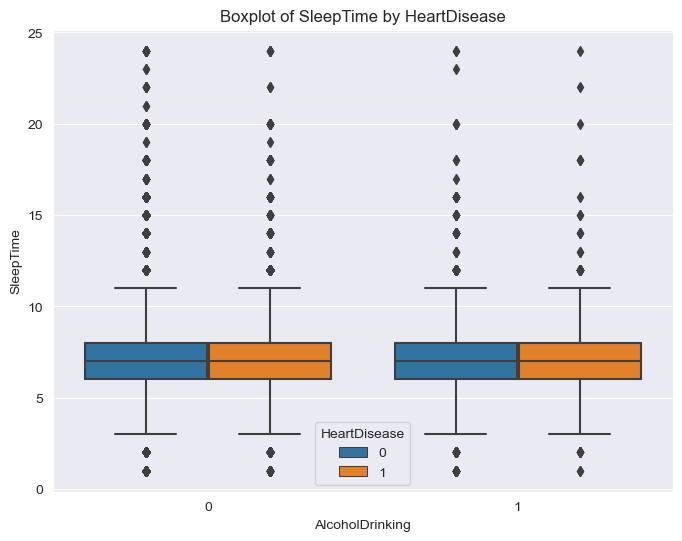

In [179]:
data_visualization = DataVisualization(data_pre_processing.data_loader)
data_visualization.plot_all_features()
data_visualization.plots(['box'])

# Delete duplicated data

Ensuring the reliability of datasets is paramount in data analysis. The assess_quality function outlined below tackles this by addressing duplicate entries and outliers. Initial steps involved purging duplicates, followed by meticulous outlier identification and correction.


In [180]:
data_analysis_instance.assess_quality()

NameError: name 'data_analysis_instance' is not defined

# Countplots for Categorical Features

Let's visualize the distribution of our categorical features using countplots. These plots provide a clear overview of the frequency of each category within the dataset.


In [ ]:
data_analysis_instance.plots(['count'])

## Correlation
This heatmap visually represents the correlations between variables, with color gradients indicating the strength and direction of these relationships. In our specific analysis focused on HeartDisease, we assessed the correlations with various features. The correlation values, presented below, showcase the degree of association:

In [ ]:
data_analysis_instance.plots(['correlation'])